In [1]:

from utils.trainfiles import TrainFiles
from utils.dataloader import DataLoader
from model.unet import UNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    print('GPU ready')
else:
    print('Warning: only CPU found')

GPU ready


In [1]:
import numpy as np
import utils.normalization as normalization
from utils.activitymap import get_frames_position
from utils.open_file import open_file

filepath = "/home/stephan/Desktop/glutamate_data/martin_23-12-21/Glu-WT_R3-2.nd2"
window_size = 50
n_threads = 30
min_z_score = 3
kernel_size = 32
roi_size = 8
foreground_background_split = 0.5

tmp_file = open_file(filepath)


In [2]:
# find train examples with activity
tmp_file_rolling_normalization = normalization.rolling_window_z_norm(
    tmp_file, window_size, n_threads=n_threads
)


In [4]:
import tifffile
tifffile.imwrite('/home/stephan/Desktop/normalized_glut_example.tif',tmp_file_rolling_normalization)

In [3]:
from utils.activitymap import compute_activitymap
activitymap_ = compute_activitymap(tmp_file_rolling_normalization,kernel_size,roi_size,n_threads)

In [5]:
activitymap_.shape

(2100, 25, 25)

2.377707685309568


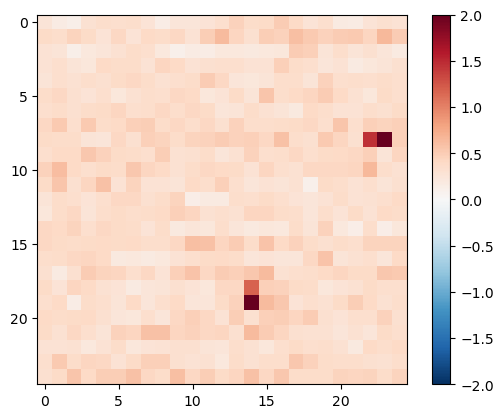

In [18]:
import matplotlib.pyplot as plt
frame = 401
print(np.max(activitymap_[frame]))
plt.imshow(activitymap_[frame],cmap='RdBu_r',vmin=-2,vmax=2)
plt.colorbar()

In [8]:
np.argwhere(activitymap_>2)

array([[ 201,    8,   22],
       [ 201,    8,   23],
       [ 401,    8,   23],
       [ 401,   19,   14],
       [ 403,   19,   14],
       [ 501,    8,   22],
       [ 501,    8,   23],
       [ 502,    8,   23],
       [ 801,    8,   23],
       [ 901,    8,   23],
       [1101,    8,   23],
       [1200,   14,   16],
       [1201,   14,   16],
       [1348,    5,   24],
       [1500,    8,   23],
       [1501,    8,   23],
       [1800,    8,   22],
       [1800,    8,   23],
       [1800,   14,   16],
       [1801,    8,   23],
       [1900,   19,   14],
       [2078,    8,   23]])

In [10]:
# will go through all frames and extract events that within a meaned kernel exceed the
# min_z_score threshold
# returns a list of events in the form [frame, y-coord, x-coord]
from importlib import reload
import utils.activitymap
reload(utils.activitymap)
from utils.activitymap import get_frames_position
frames_and_positions = get_frames_position(
    tmp_file_rolling_normalization, 2, kernel_size, 4, foreground_background_split, n_threads
)


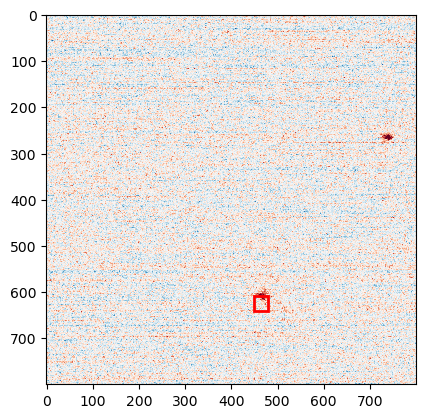

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
frame,y,x = [401, 608, 448]
plt.imshow(tmp_file_rolling_normalization[frame],cmap='RdBu_r',vmin=-2,vmax=2)
rectangle = patches.Rectangle((x, y), kernel_size, kernel_size, edgecolor='r', linewidth=2, facecolor='none')
plt.gca().add_patch(rectangle)

In [11]:
frames_and_positions

[[101, 256, 736],
 [102, 256, 736],
 [201, 256, 704],
 [201, 256, 736],
 [201, 416, 256],
 [201, 448, 256],
 [202, 256, 704],
 [202, 256, 736],
 [301, 256, 736],
 [301, 448, 256],
 [301, 448, 288],
 [401, 256, 736],
 [401, 608, 448],
 [402, 608, 448],
 [403, 576, 448],
 [403, 608, 448],
 [501, 256, 704],
 [501, 256, 736],
 [502, 256, 704],
 [502, 256, 736],
 [714, 448, 288],
 [801, 256, 704],
 [801, 256, 736],
 [802, 256, 736],
 [901, 256, 704],
 [901, 256, 736],
 [902, 256, 736],
 [1100, 256, 736],
 [1101, 256, 704],
 [1101, 256, 736],
 [1200, 256, 736],
 [1200, 448, 512],
 [1201, 256, 704],
 [1201, 448, 512],
 [1300, 256, 736],
 [1348, 160, 768],
 [1400, 256, 672],
 [1500, 256, 704],
 [1500, 256, 736],
 [1501, 256, 704],
 [1501, 256, 736],
 [1700, 256, 704],
 [1800, 256, 704],
 [1800, 256, 736],
 [1800, 384, 544],
 [1800, 448, 512],
 [1801, 256, 704],
 [1801, 256, 736],
 [1900, 256, 736],
 [1900, 576, 448],
 [1900, 608, 448],
 [1901, 576, 448],
 [1901, 608, 448],
 [2000, 256, 736],
 

In [ ]:

mean = np.mean(tmp_file,axis=0)
std = np.std(tmp_file,axis=0)
tmp_file = normalization.z_norm(tmp_file, mean, std)

# Generate trainfiles.json

In [2]:
trainfiles = TrainFiles('trainfiles.yaml',True)
trainfiles.find_files('/home/stephan/Desktop/',['.stk'], 4, 16)

100%|██████████| 67/67 [1:22:27<00:00, 73.84s/it]


# Train UNet

In [1]:
import yaml
trainconfigdict = {'batch_size': 32,
                   'n_pre': 2,
                   'n_post': 2,
                   'train_height': 32,
                   'train_width': 32,
                   'load_multiple_targets': True,
                   'num_epochs': 1,
                   'learning_rate': 0.0001
                   }
with open('trainconfig.yaml','w') as f:
    yaml.dump(trainconfigdict,f)

In [ ]:
dataloader = DataLoader(trainfiles,batch_size=32,n_pre=2,n_post=2,train_height=16,train_width=16,load_multiple_targets_per_file=True,n_multiple_targets=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(dataloader.n_pre + dataloader.n_post).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

In [4]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    i = 0
    while not dataloader.epoch_done:
        batch_generated = dataloader.get_batch()
        if not batch_generated:
            break
        data = dataloader.X.to(device)
        targets = dataloader.y.to(device)
        model.train()
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Batch {i+1} (samples {(i+1)*dataloader.batch_size}), Loss: {loss.item()}')
        i += 1
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    dataloader.shuffle_array()

Batch 1 (samples 32), Loss: 4.078166961669922
Batch 11 (samples 352), Loss: 3.8579511642456055
Batch 21 (samples 672), Loss: 3.7429864406585693
Batch 31 (samples 992), Loss: 3.669079303741455
Batch 41 (samples 1312), Loss: 3.4762182235717773
Batch 51 (samples 1632), Loss: 3.5313189029693604
Batch 61 (samples 1952), Loss: 3.48209810256958
Batch 71 (samples 2272), Loss: 3.399083375930786
Batch 81 (samples 2592), Loss: 3.249934673309326
Batch 91 (samples 2912), Loss: 3.491363525390625
Batch 101 (samples 3232), Loss: 3.2920379638671875
Batch 111 (samples 3552), Loss: 3.439922332763672
Batch 121 (samples 3872), Loss: 3.254117965698242
Batch 131 (samples 4192), Loss: 3.4335179328918457
Batch 141 (samples 4512), Loss: 3.3242883682250977
Batch 151 (samples 4832), Loss: 3.371424436569214
Batch 161 (samples 5152), Loss: 3.0397276878356934
Batch 171 (samples 5472), Loss: 2.8457024097442627
Batch 181 (samples 5792), Loss: 3.033780097961426
Batch 191 (samples 6112), Loss: 2.8577585220336914
Batch 2

KeyboardInterrupt: 

4,412 iterations (141,209 samples)

In [5]:
torch.save(model.state_dict(),'unet.pt')

In [4]:
model.load_state_dict(torch.load('unet.pt'))

<All keys matched successfully>

In [6]:
dataloader.get_batch()
data = dataloader.X.to(device)
targets = dataloader.y.to(device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
pred = np.array(model(data).detach().to('cpu'))


In [8]:
pred[0].shape

(1, 16, 16)

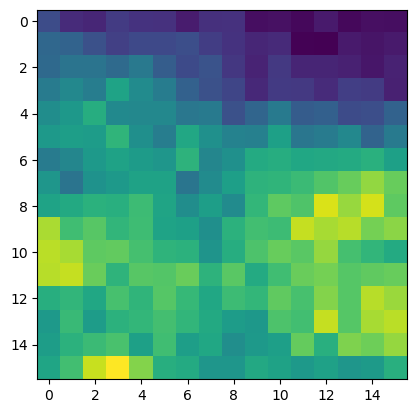

In [11]:
plt.imshow(np.array(targets.detach().to('cpu'))[0].reshape(16,16))

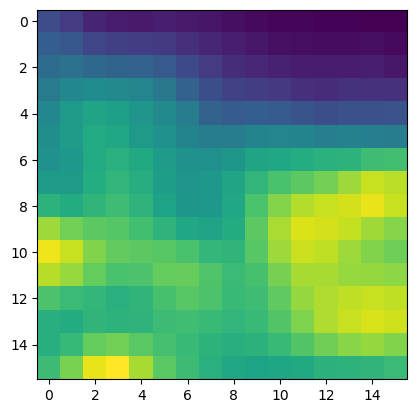

In [9]:
plt.imshow(pred[0].reshape(16,16))

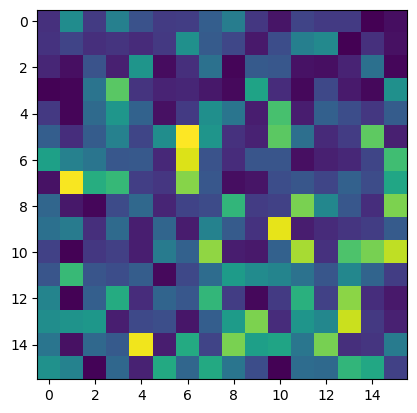

In [14]:
target_ = np.array(targets.detach().to('cpu'))[0].reshape(16,16)
pred_ = pred[0].reshape(16,16)
diff = abs(target_-pred_)
plt.imshow(diff)

In [20]:
from importlib import reload
import model.modelwrapper
reload(model.modelwrapper)
from model.modelwrapper import ModelWrapper
wrapper = ModelWrapper('unet.pt',2,2)

In [22]:
img_denoised = wrapper.denoise_img('/home/stephan/Desktop/students_10.05._old/Bachelorkurs_2023/Coverslip2 evoked spontan R8 ttx.stk')

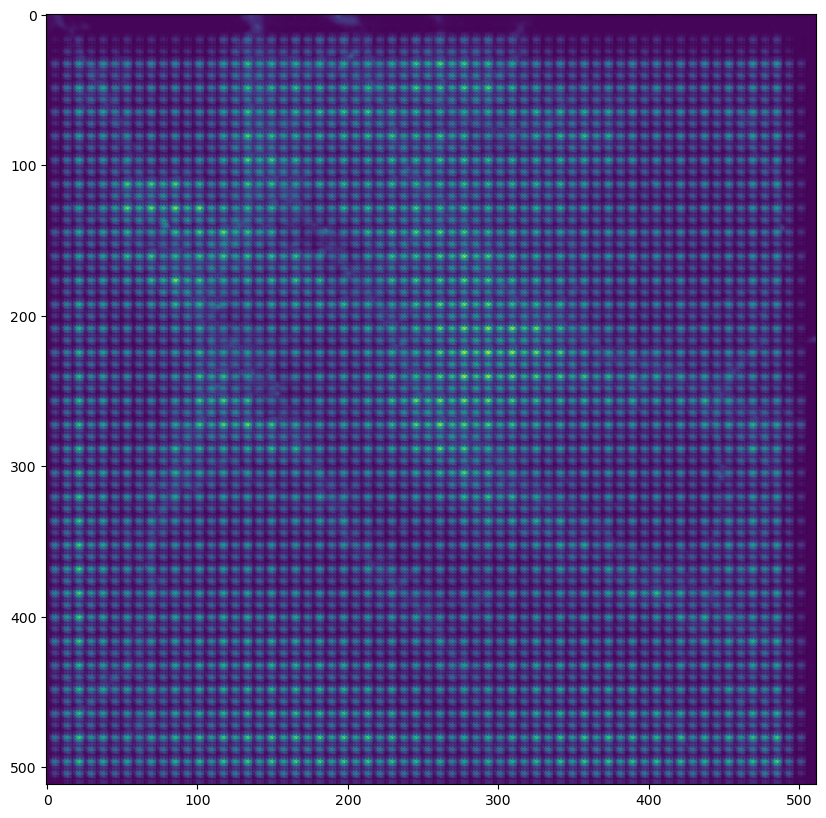

In [26]:
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
ax.imshow(img_denoised[20])

In [33]:
from utils.normalization import reverse_z_norm
xxx = img_denoised[:,200:220,200:220]
yyy = reverse_z_norm(wrapper.img[2:-2,200:220,200:220],wrapper.img_mean,wrapper.img_std)

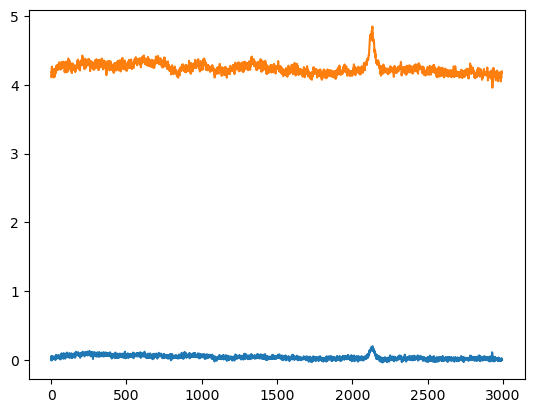

In [35]:
from utils.normalization import z_norm

plt.plot(z_norm(yyy.mean(axis=(1,2)),wrapper.img_mean,wrapper.img_std))
plt.plot(z_norm(xxx.mean(axis=(1,2)),wrapper.img_mean,wrapper.img_std))